In [3]:
import numpy as np
model_count = 5
y_pred = [np.zeros((len(x), model_count), dtype=np.float32) for x in [(1,1),(1,1),(1,1),(1,1),(1,1)]]
print(y_pred)
print(model_count)

[array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)]
5


In [ ]:
import psutil

# 获取CPU核心数量
num_cores = psutil.cpu_count(logical=False)

# 循环获取每个CPU核的利用率
for i in range(num_cores):
    cpu_percent = psutil.cpu_percent(interval=1, percpu=True)
    print(f"CPU核心 {i+1} 的利用率: {cpu_percent[i]}%")

In [ ]:
import psutil
import os 
import subprocess
cpu_list = [10,11,12,13]

psutil.Process().cpu_affinity(cpu_list)
process = subprocess.Popen(['python3','simple_test.py'])

while process.poll() is None:
    # cpu_percent = psutil.Process(process.pid).cpu_percent(interval=1)
    cpu_percent = psutil.cpu_percent(interval=1,percpu=True)
    for core,percent in enumerate(cpu_percent):
        if core in cpu_list:
            print(f"核心{core}的利用率: {percent}%")
    print(f"新程序在CPU上的利用率: {cpu_percent}%")
    
    # 等待新程序运行结束
process.wait()

In [6]:
from colmena.thinker import BaseThinker, result_processor, task_submitter, ResourceCounter
from colmena.queue import PipeQueues
from colmena.models import Result

from colmena.task_server import ParslTaskServer
from config import csecluster_RT_scale as make_config

"""Example from the README"""

##  Building the Thinker
from random import random

# Build queues to connect Thinker and Doer
queues = PipeQueues()


class Thinker(BaseThinker):

    def __init__(self, queues, num_workers: int, num_guesses=100):
        super().__init__(queues, ResourceCounter(num_workers))
        self.best_result = None
        self.answer = -10  # A (bad) starting guess
        self.num_guesses = num_guesses

    @task_submitter()
    def submit_task(self):
        """Submit a new guess close to the current best whenever a node is free"""
        self.queues.send_inputs(self.answer - 1 + 2 * random(), method='simulate')

    @result_processor()
    def store_result(self, result: Result):
        """Update best guess whenever a simulation finishes"""
        assert result.success, result.failure_info
        # Update the best result
        if self.best_result is None or result.value > self.best_result:
            self.answer = result.args[0]
            self.best_result = result.value
        self.rec.release()  # Mark that a node is now free

        # Determine if we are done
        self.num_guesses -= 1
        if self.num_guesses <= 0:
            self.done.set()


thinker = Thinker(queues, 8)

### Building the doer
# from parsl.configs.htex_local import config  # Configuration to run locally
from colmena.task_server import ParslTaskServer
config = make_config("./")


# Define your function
def simulate(x: float) -> float:
    return - x ** 2 + 4


# Make the Doer
doer = ParslTaskServer([simulate], queues, config)

# print(doer.config.executors)
# gpu_executor = [executor for executor in doer.config.executors if executor.label == 'gpu'][0]
# print(gpu_executor)
a=doer.config.executors
## Running the application
# Launch the Thinker and doer
# doer.start()
# thinker.start()

# # Wait until it finishes
# thinker.join()
# queues.send_kill_signal()

# # Done!
# print(f'Answer: f({thinker.answer:.2f}) = {thinker.best_result:.2f}')

In [6]:
debug = "debug"
max_workers = 4
accelerators = [0,1,2,3]
block_id = 1
l_cmd = ("process_worker_pool.py {debug} {max_workers} "
                               "--available-accelerators {accelerators} ")
cmd = l_cmd.format(debug=debug, max_workers=max_workers, accelerators = accelerators)
print(cmd)
l_cmd = l_cmd.replace("{accelerators}", str(block_id))
launch_cmd = l_cmd.format(debug=debug, max_workers=max_workers)
print(launch_cmd)



process_worker_pool.py debug 4 --available-accelerators [0, 1, 2, 3] 
process_worker_pool.py debug 4 --available-accelerators 1 


In [12]:
import json
import os
from pathlib import Path
file = Path('/home/lizz_lab/cse12232433/project/colmena/multisite_/finetuning-surrogates/runs/20230920_204954/dft-md-23Sep20-125003-d91b7e/simulation-results.json')

tasks = []
with open(file, 'r') as file:
    # 逐行读取文件内容
    for line in file:
        # 解析 JSON 数据
        task_info = []
        data = json.loads(line)
        task_info.append(data['task_id'])
        task_info.append(data['task_info'])
        task_info.append(data['time_running'])
        tasks.append(task_info)

print(data['task_id'])
sorted_tasks = sorted(tasks, key=lambda x: x[2], reverse=True)
for i in range(len(tasks)):
    # print(sorted_tasks[i][1]['xyz'])
    # print(tasks[i][2])
    print(sorted_tasks[i][2])
    print(sorted_tasks[i][1]['task_type'])

463bbc41-d4bf-44d5-8b37-d13f6fba739d
1456.556674147956
audit
1321.1727346020052
audit
1092.2011626909953
audit
1026.4671867439756
audit
784.6231484480668
audit
610.6691218329361
audit
543.8459851499647
audit
537.9019012070494
audit
521.3457018379122
audit
486.8927287670085
active
481.90589529590216
audit
454.6108865479473
active
400.35233247396536
active
390.35370990703814
audit
296.3696234700037
audit
210.88306554197334
audit
127.46185084490571
audit
106.35893604997545
active
95.27356048696674
audit
44.38919379503932
audit


In [5]:
# a=tasks[0]
# print(a[1])

{'traj_id': 596, 'task_type': 'audit', 'ml_energy': -20779.595703125, 'xyz': '30\n\nO       0.331852683959424      0.480711861922854      0.105067261566631\nH       0.462329708669922      0.562497232115342      1.037376249778990\nH       0.856985603967945     -0.278753974365024     -0.160776906750427\nO      -2.286932512619368      0.784293758116149      0.076791792428081\nH      -1.329573545324915      0.622167012761134      0.031146113084200\nH      -2.505146775742542      0.346527731319279      0.953387037182454\nO       1.343960507357838      3.067183081667494     -0.565682845061429\nH       1.901836245672660      2.938733285854801      0.247007947395470\nH       0.900014038272543      2.201382133369581     -0.607900321909409\nO       0.336688452734651     -0.355465815231568      2.853729148554045\nH       0.783013367282798      0.268315846016201      3.471594956470549\nH      -0.544003004523993     -0.022824808684152      2.602039887493498\nO       0.912067557974026     -0.0020588

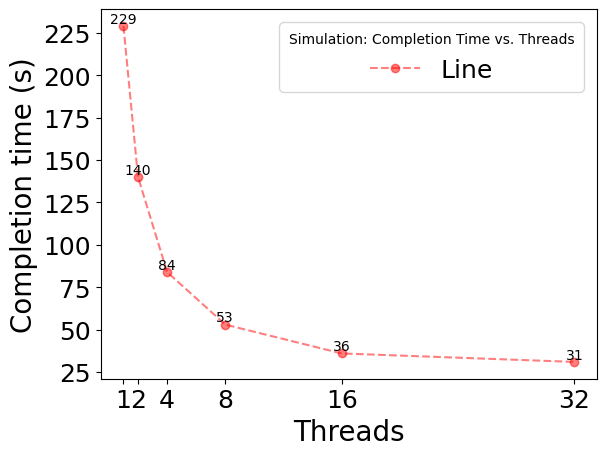

In [2]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

y = [229, 140, 84, 53, 36, 31]
x = [1, 2, 4, 8, 16, 32]

# 绘制柱状图
# plt.bar(x, y)
plt.plot(x, y, marker='o', color='red', linestyle='--', label='Line', alpha=0.5)
# 可选：添加标题和标签
# plt.title('Simulation performance')
plt.xlabel('Threads',fontsize=20)
plt.ylabel('Completion time (s)',fontsize=20)
plt.legend(title='Simulation: Completion Time vs. Threads',prop={'size': 18}, loc='upper right', fontsize=18)

# 标出每个柱的值
for i in range(len(x)):
    plt.text(x[i], y[i], str(y[i]), ha='center', va='bottom')

ax = plt.gca()  # 获取当前坐标轴对象
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))  # 设置x轴刻度的最大数量为5个
plt.xticks(x, x, fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('simulation performance.png')
plt.show()


